In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import pandas as pd
import vice

In [3]:
import surp
from surp.src.analysis.vice_model import vice_model
import surp.src.analysis.apogee_analysis as aah
from surp.src.analysis import plotting_utils as pluto
import arya

arya.save_at("./figures")

from scipy.stats import binned_statistic
from scipy.integrate import quad
from scipy.interpolate import interp1d, interp2d, CubicSpline
from scipy.optimize import curve_fit
import scipy

In [18]:
plt.rcParams["figure.dpi"] = 200

In [10]:
df = aah.subgiants
filt = ~np.isnan(df["MG_H"])
filt &= ~np.isnan(df["C_MG"])
subgiants = df[filt].copy() #low alpha is closer to equilibrium

subgiants["C_MG_ERR"] = subgiants["C_FE_ERR"] + subgiants["MG_FE_ERR"]
subgiants["N_MG_ERR"] = subgiants["MG_FE_ERR"] + subgiants["N_FE_ERR"]
subgiants["C_N_ERR"] = subgiants["N_FE_ERR"] + subgiants["C_FE_ERR"]

In [11]:
def find_model(name):
    """
    Finds the pickled model with either the given name or the parameters 
    and returns the vice_model object
    """
    
    file_name = "../results/" + name + ".csv"
    df =  pd.read_csv(file_name)
    df["C_N"] = df["C_MG"] - df["N_MG"]
    return df


In [45]:
def binned_stats(x, y, yerr=None, bins=30, range=(-0.4, 0.4), err_mean=False):
    
    counts, edges, _ = binned_statistic(x, y, bins=bins, range=range, statistic="count")
    
    means, _, _ = binned_statistic(x, y, bins=bins, range=range, statistic="median")
    stds, _, _ = binned_statistic(x, y, bins=bins, range=range, 
                                  statistic=lambda x: scipy.stats.median_abs_deviation(x, scale="normal"))
    errs = stds   
    xs = (edges[:-1] + edges[1:])/2
    return xs, means, errs

In [46]:
s0 = 5

def zooh_data(y="C_MG", ax=None, **kwargs):
    """
    Plots the mean trend of apogee subgiants
    
    ax: plot axis
    ele: y axis element
    params: passed to 
    
    """
    if ax is None:
        ax = plt.gca()
        
    df = subgiants[~subgiants.high_alpha]
    
    x, y, yerr = binned_stats(df.MG_H, df[y], df[y + "_ERR"])
    
    plt.scatter(x, y, color="k", s=s0)
    plt.scatter(x, y-yerr, marker="_", color="k", alpha=0.3, s=s0)
    plt.scatter(x, y+yerr, marker="_", color="k", alpha=0.3, s=s0)

    
def zoofe_data(y="C_MG", mg_0=-0.1, w=0.05, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    filt = subgiants["MG_H"] > mg_0 - w
    filt &= subgiants["MG_H"] < mg_0 + w
    df = subgiants[filt]

    x, y, yerr = binned_stats(subgiants.MG_FE, subgiants[y], subgiants[y + "_ERR"], range=[-0.05, 0.35])
    
    plt.scatter(x, y, color="k", s=s0)
    plt.scatter(x, y-yerr, marker="_", color="k", alpha=0.3, s=s0)
    plt.scatter(x, y+yerr, marker="_", color="k", alpha=0.3, s=s0)

In [56]:
def zooh_models(models, y="C_MG", ax=None):
    if ax is None:
        ax = plt.gca()
        
    name_0 = list(models.keys())[0]
    i = 0
    for name, model in models.items():
        xdat, ydat, yerr = binned_stats(model["MG_H"], model[y], range=(-0.6, 0.6))
        ax.plot(xdat, ydat, label=name)

    zooh_data(y=y, zorder=-2)

def zoofe_models(models: dict, y="C_MG", mg_0=0.1, w=0.05, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    name_0 = list(models.keys())[0]


    for name, model in models.items():
        filt = model.MG_H > mg_0 - w
        filt &= model.MG_H < mg_0 + w
        df = model[filt]
        xdat, ydat, yerr = binned_stats(df["MG_FE"], df[y], range=(-0.2, 0.4))
        ax.plot(xdat, ydat)
    
    zoofe_data(y=y, mg_0=mg_0, w=w, zorder=-2)

In [87]:
def compare(names, labels, y = "C_MG", ylabel="[C/Mg]", filename=None, ylim=(-0.3, 0.1)):
    models = {label: find_model(name) for name, label in zip(names, labels)}
    
    jp = arya.JoinPlot(1, 2)

    sp = jp.children[0][0]

    plt.sca(sp.mpl_ax)
    zooh_models(models, y=y)  

    sp.x.label = f"[Mg/H]"
    sp.y.label = ylabel
    sp.x.lim = (-0.6, 0.6) 
    sp.y.lim = ylim
    sp.x.ticks = [-0.6, -0.4, -0.2, 0, 0.2, 0.4]
    pluto.fancy_legend(ax=sp.mpl_ax, colors=arya.style.COLORS)

    
    sp = jp.children[0][1]
    plt.sca(sp.mpl_ax)
    zoofe_models(models, y=y)
    
    
    sp.x.label = r"[Mg/Fe]"
    sp.y.label = r""
    sp.x.lim = (-0.15, 0.4)
    sp.mpl_ax.set_title("")
    
    if filename is not None:
        sp.save(filename)


one file saved at ./figures/nitrogen.pdf


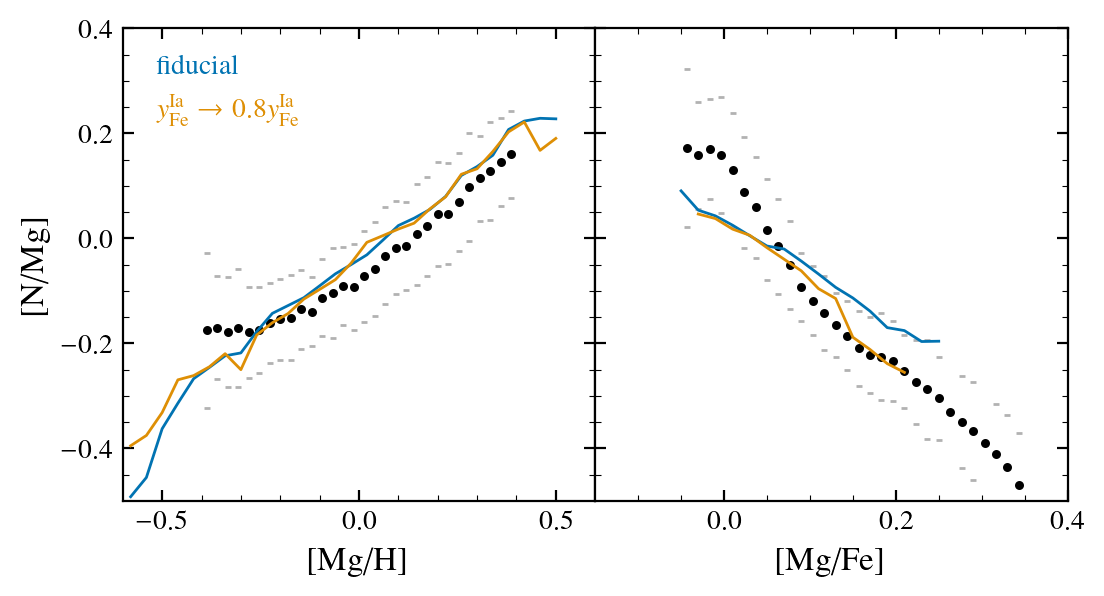

In [88]:
names = ["C11_f0.2_eta1_beta0.001", "C11_f0.2_eta1_beta0.001_Fe0.8"]
labels = ["fiducial", r"$y_{\rm Fe}^{\rm Ia} \rightarrow 0.8y_{\rm Fe}^{\rm Ia}$"]
compare(names, labels, y="N_MG", filename="nitrogen.pdf", ylabel="[N/Mg]", ylim=(-0.5, 0.4))


one file saved at ./figures/c_n.pdf


(-0.5, 0.4)

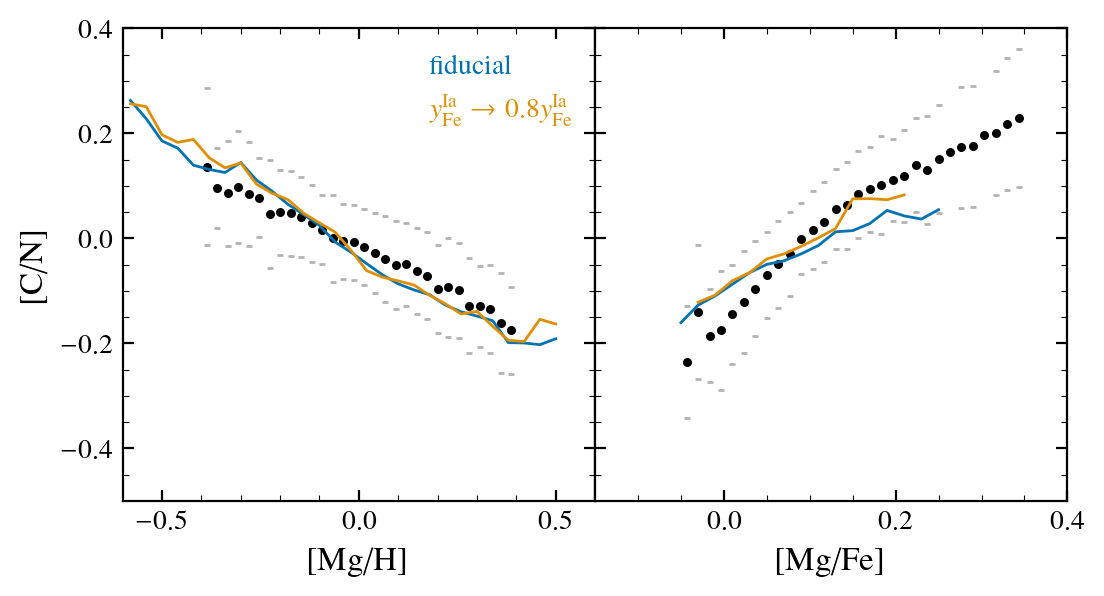

In [91]:
names = ["C11_f0.2_eta1_beta0.001", "C11_f0.2_eta1_beta0.001_Fe0.8"]
labels = ["fiducial", r"$y_{\rm Fe}^{\rm Ia} \rightarrow 0.8y_{\rm Fe}^{\rm Ia}$"]
compare(names, labels, y="C_N", filename="c_n.pdf", ylabel="[C/N]",  ylim=(-0.3, 0.4))
plt.ylim(-0.5, 0.4)

one file saved at ./figures/agb_oob.pdf


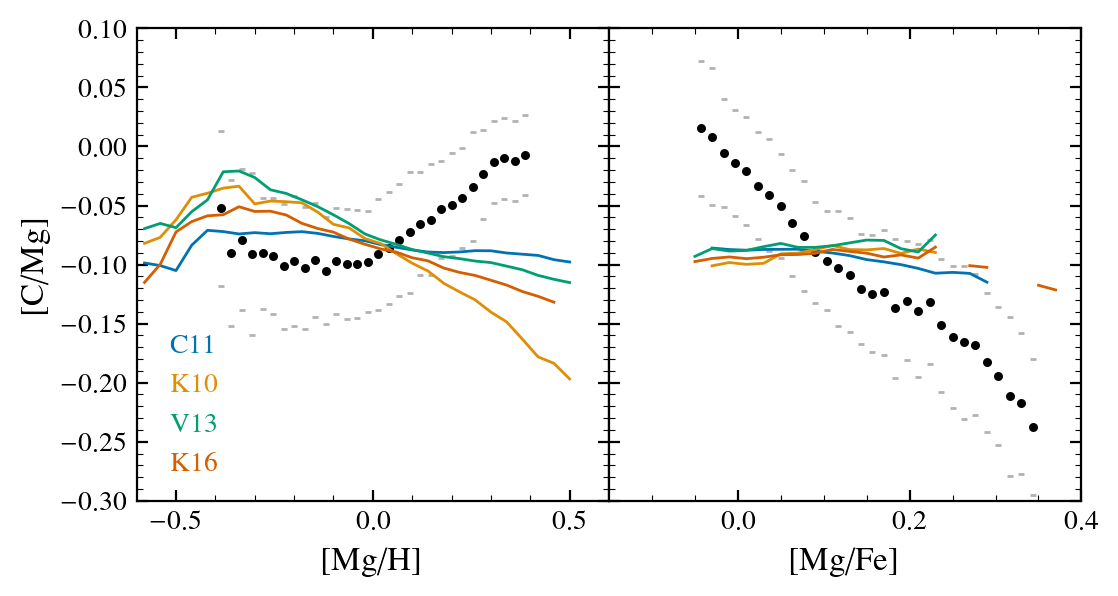

In [76]:
names = ["C11_f0.2_OOB_eta1_beta0",
        "K10_f0.2_OOB_eta1_beta0",
        "V13_f0.2_OOB_eta1_beta0",
        "K16_f0.2_OOB_eta1_beta0"]
labels = ["C11", "K10", "V13", "K16"]
compare(names, labels, filename="agb_oob.pdf")

one file saved at ./figures/f_agb.pdf


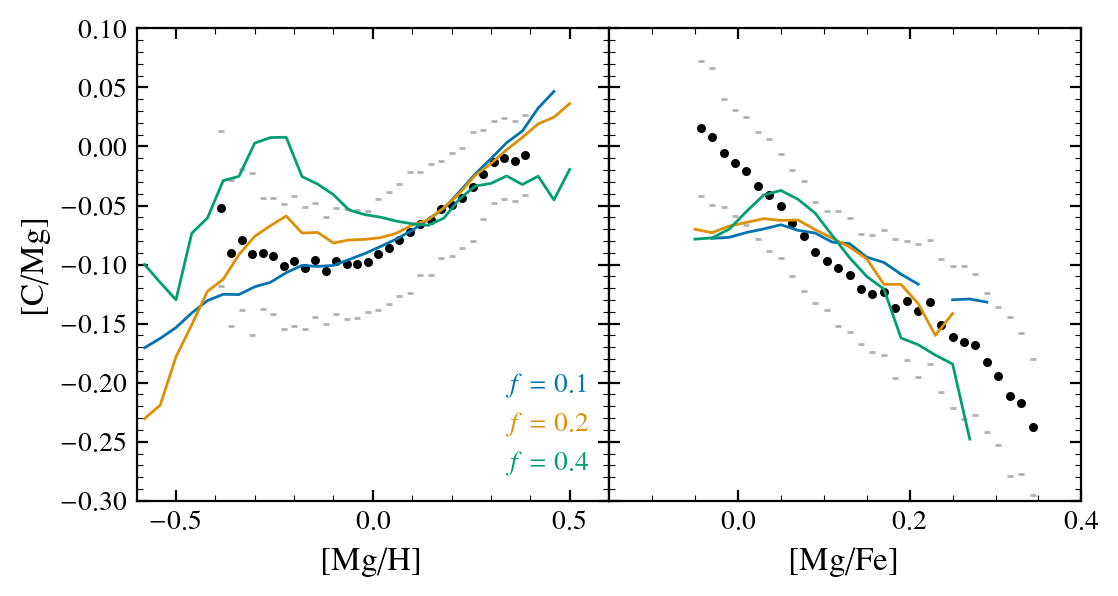

In [77]:
names = ["C11_f0.1_eta1_beta0.001", "C11_f0.2_eta1_beta0.001", "C11_f0.4_eta1_beta0.001"]

labels = ["$f=0.1$", "$f=0.2$", "$f=0.4$"]
compare(names, labels, filename="f_agb.pdf")

one file saved at ./figures/beta.pdf


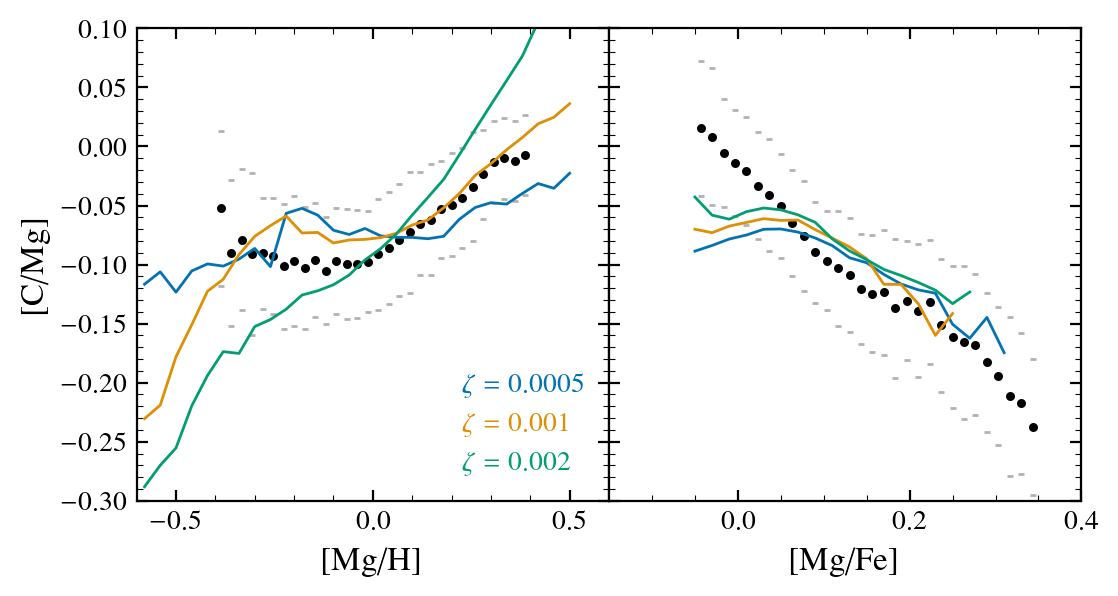

In [78]:

names = ["C11_f0.2_eta1_beta0.0005", "C11_f0.2_eta1_beta0.001", "C11_f0.1_eta1_beta0.002"]

labels = [r"$\zeta=0.0005$", r"$\zeta=0.001$", r"$\zeta=0.002$"]
compare(names, labels, filename="beta.pdf")


one file saved at ./figures/lateburst_eta.pdf


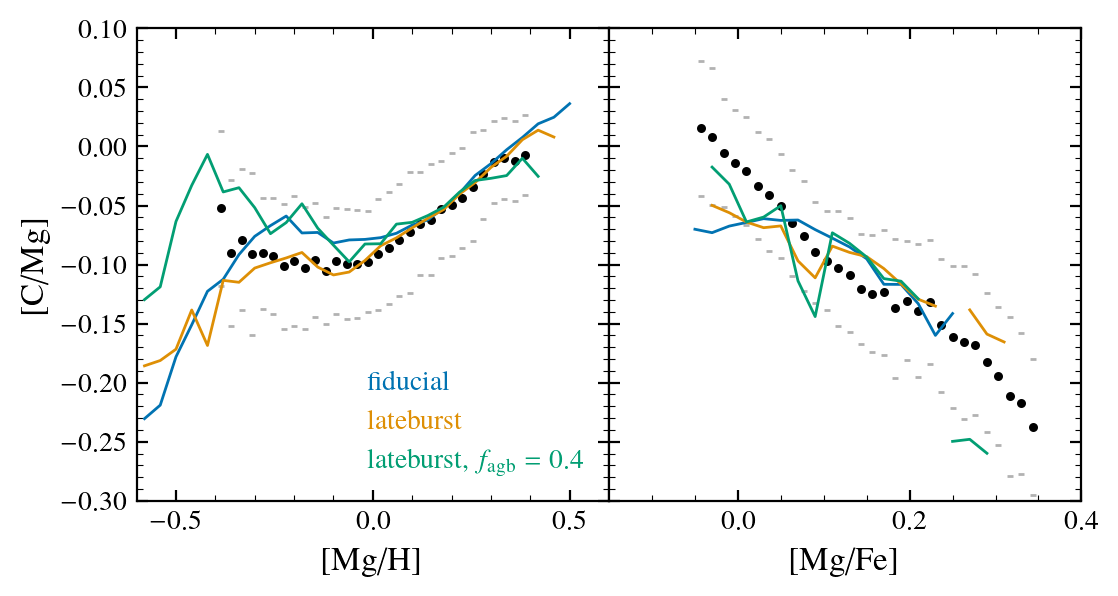

In [85]:
names = ["C11_f0.2_eta1_beta0.001", "C11_f0.2_eta1_beta0.001_lateburst1.5", 
         "C11_f0.4_eta1_beta0.001_lateburst1.5"]

labels=["fiducial", "lateburst", "lateburst, $f_{\\rm agb}=0.4$", r"$y_{\rm C,0}^{\rm CC}=0.001$"]
compare(names, labels, filename="lateburst_eta.pdf")


one file saved at ./figures/eta.pdf


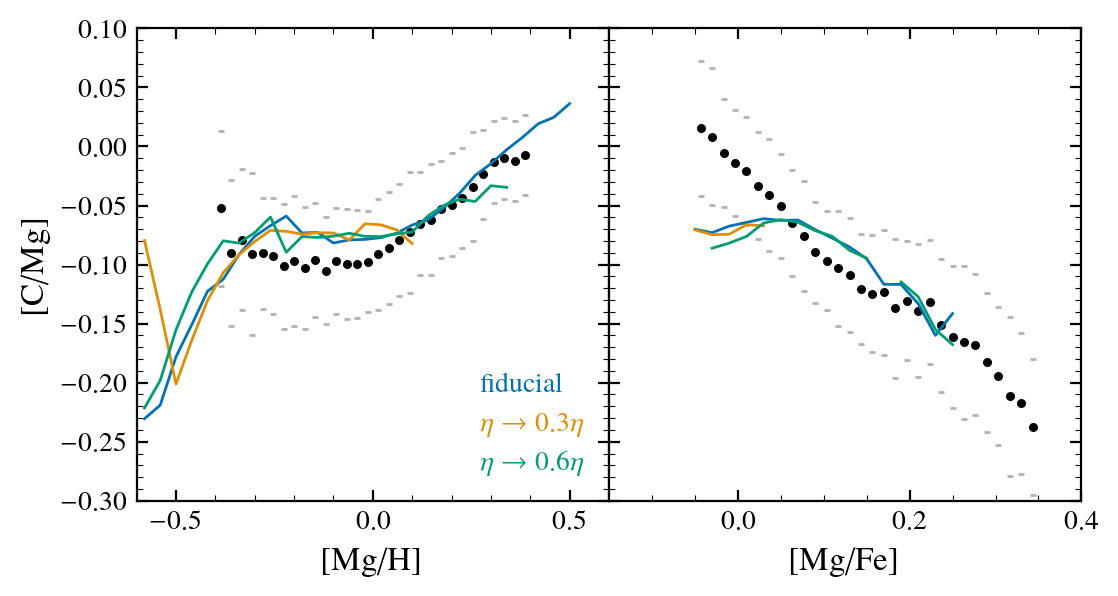

In [80]:
names = ["C11_f0.2_eta1_beta0.001", "C11_f0.2_eta0.3_beta0.001", "C11_f0.2_eta0.6_beta0.001"]

labels=["fiducial", r"$\eta\rightarrow0.3\eta$", r"$\eta\rightarrow0.6\eta$"]
compare(names, labels, filename="eta.pdf")

one file saved at ./figures/agb2.pdf


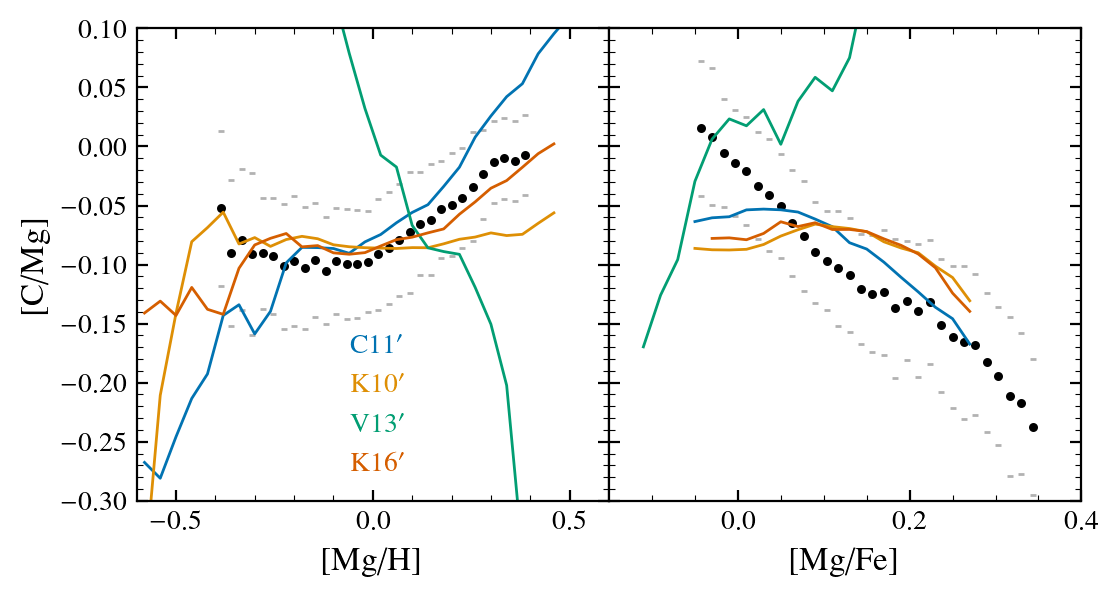

In [81]:
names = ["C11_f0.2_eta1_beta0.002",
        "K10_f0.2_eta1_beta0.002",
        "V13_f0.2_eta1_beta0.002",
        "K16_f0.2_eta1_beta0.002"]

labels = ["C11$'$", "K10$'$", "V13$'$", "K16$'$"]
models = {label: find_model(name) for name, label in zip(names, labels)}
compare(names, labels, filename="agb2.pdf")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


one file saved at ./figures/coofe_agb_extra_0.2.pdf


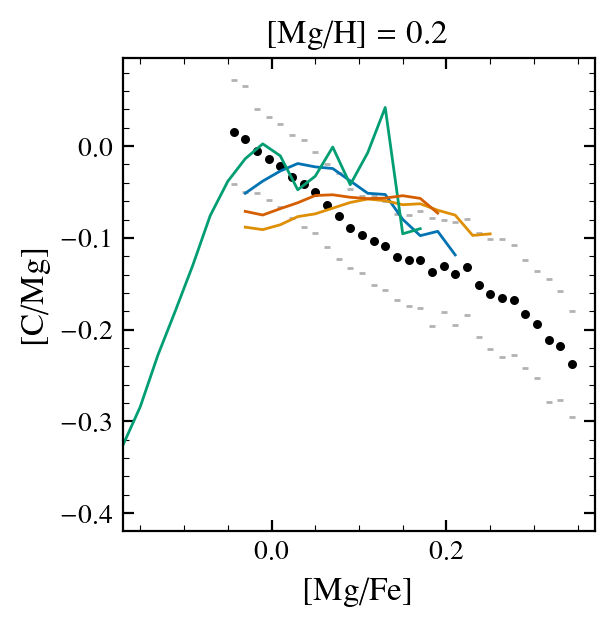

In [82]:
sp = arya.Subplot()
zoofe_models(models, mg_0=0.2)
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.xlim(-0.17)
pluto.fancy_legend()
plt.title(r"$[\text{Mg/H}]=0.2$", fontsize="large")

sp.save("coofe_agb_extra_0.2.pdf")

one file saved at ./figures/coofe_agb_extra.pdf


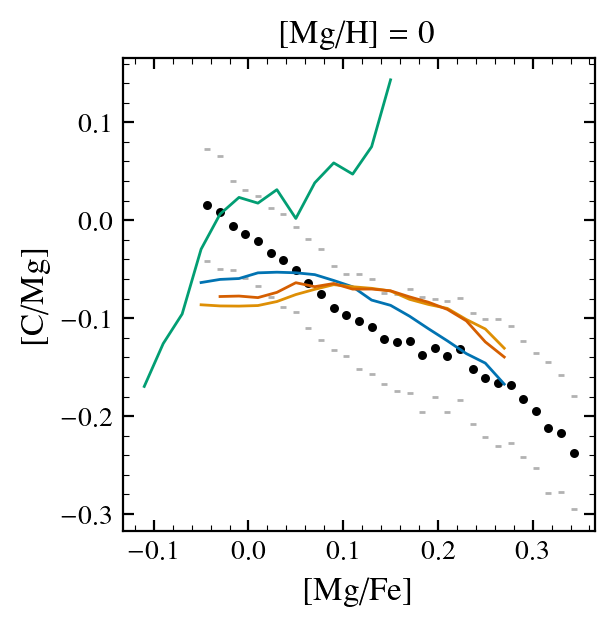

In [83]:
sp = arya.Subplot()
zoofe_models(models, mg_h=0)

plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.title(r"$[\text{Mg/H}]=0$", fontsize="large")
sp.save("coofe_agb_extra.pdf")

one file saved at ./figures/fe_ia.pdf


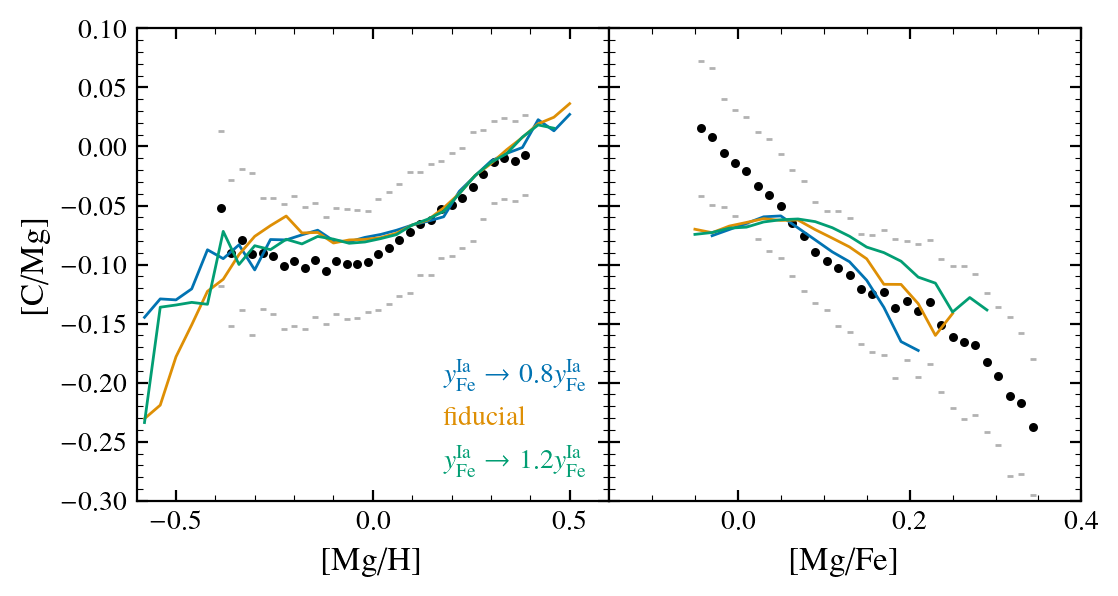

In [84]:
names = ["C11_f0.2_eta1_beta0.001_Fe0.8",
         "C11_f0.2_eta1_beta0.001",
         "C11_f0.2_eta1_beta0.001_Fe1.2"]

labels = [r"$y_{\rm Fe}^{\rm Ia} \rightarrow 0.8y_{\rm Fe}^{\rm Ia}$",
         "fiducial",
         r"$y_{\rm Fe}^{\rm Ia} \rightarrow 1.2y_{\rm Fe}^{\rm Ia}$"]
models = {label: find_model(name) for name, label in zip(names, labels)}
compare(names, labels, filename="fe_ia.pdf")